<h1> Final Project 1 Jupyter Notebook: India, Pakistan, and Bangladesh </h1>
<h2> Group 1: Dorothy Thomas </h2>
<br/>
<p>Authors: Rishi Boddu, Kita Hu, Sage Tulabing, Leanna Baltonado</p>
<br/>
<p>In this Jupyter Notebook, we'll be introducing population functions, population pyramid functions and more in order to quantify the 1994 Rwandan Genocide using data analysis. We primarily utilize the WBData Population dataset in order to compile data containing population for each age, gender, year, and country. We cite the information from WB Data. https://wbdata.readthedocs.io. We primarily aim to analyze the 1994 Rwandan Genocide using graphs and visualizations.</p>

In [33]:
%pip install wbdata
from __future__ import annotations
import time
from functools import lru_cache
from typing import Literal
import wbdata
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt


Note: you may need to restart the kernel to use updated packages.


# Table of Contents

- [1. Population DataFrame Function](#below-is-the-main-population-dataframe-function)
- [2. Population Statistics Function](#population-tatistics)
- [3. Unit Test](#unit-test)
- [4. Population Pyramid](#population-pyramid)
- [Population Rate Analysis] (#population-growth-rate)
- [Bangladesh Rural vs Urban](#bangladesh-rural-vs-urban)
- [India Population Pyramid](#india-population-pyramid)
- [Conclusion](#conclusion)

# 1. Population DataFrames [A]

### Helper Functions

In [34]:
#Helper Functions

Sex = Literal["female", "male", "total"]

AGE_BINS_5Y = [
    "0004","0509","1014","1519","2024","2529","3034","3539",
    "4044","4549","5054","5559","6064","6569","7074","7579","80UP"
]

BIN_TO_RANGE = {
    "0004": (0,4),   "0509": (5,9),   "1014": (10,14), "1519": (15,19),
    "2024": (20,24), "2529": (25,29), "3034": (30,34), "3539": (35,39),
    "4044": (40,44), "4549": (45,49), "5054": (50,54), "5559": (55,59),
    "6064": (60,64), "6569": (65,69), "7074": (70,74), "7579": (75,79),
    "80UP": (80,200),
}

def bins_for_age_range(start_age: int, end_age: int) -> list[str]:
    ''' >>> bins_for_age_range(start_age = 0, end_age = 9)
        return: ['0004', '0509']
        '''
    return [b for b,(lo,hi) in BIN_TO_RANGE.items() if not (hi < start_age or lo > end_age)]

def wb_indicator_5y(age_code: str, sex: str) -> str:
    ''' This helper constructs variable indicator.
    >>> wb_indicator_5y(age_code = '0004', sex = 'female')
    output: "SP.POP.0004.FE"
    '''
    
    sex_code = "FE" if sex == "female" else "MA"
    return f"SP.POP.{age_code}.{sex_code}"

Below is validation helper functions

In [35]:
def _validate_years(years: tuple[int, int]) -> None:
    if (not isinstance(years, tuple)) or len(years) != 2:
        raise TypeError("years must be a tuple of (start_year, end_year)")
    y0, y1 = years
    if not (isinstance(y0, int) and isinstance(y1, int)):
        raise TypeError("years must contain integers")
    if y0 > y1:
        raise ValueError("years must satisfy start_year <= end_year")
    if y0 < 1960 or y1 > 2024:
        raise ValueError("years must be between 1960 and 2024, inclusive")


def _validate_area(area: str) -> str:
    if not isinstance(area, str):
        raise TypeError("area must be a string")
    area = area.strip()
    if not area:
        raise ValueError("area must be a non-empty string")
    return area


def _validate_sex(sex: str) -> Sex:
    if not isinstance(sex, str):
        raise TypeError("sex must be a string")
    sex = sex.strip().lower()
    if sex not in ("female", "male", "total"):
        raise ValueError("sex must be 'female', 'male', or 'total'")
    return sex  # type: ignore[return-value]


def _validate_age_range(age_range: tuple[int, int]) -> tuple[int, int]:
    if (not isinstance(age_range, tuple)) or len(age_range) != 2:
        raise TypeError("age_range must be a tuple (low, high)")
    low, high = age_range
    if not (isinstance(low, int) and isinstance(high, int)):
        raise TypeError("age_range bounds must be integers")
    if low < 0 or high < 0:
        raise ValueError("age_range bounds must be non-negative")
    if low > high:
        raise ValueError("age_range must satisfy low <= high")

    # Exact 5-year boundary validation:
    # valid ranges are unions of 5-year bins, so:
    #   low must be multiple of 5
    #   high must be 4 mod 5
    if (low % 5) != 0 or (high % 5) != 4:
        raise ValueError(
            "age_range must align to 5-year bins, e.g. (0,4), (0,9), (5,14), (15,19)"
        )

    # Optional: enforce max bound if your bins top out (e.g., 100+)
    # You can skip this if AGE_BINS_5Y already handles it robustly.
    return low, high



### Below is the main population DataFrame function.

In [36]:
@lru_cache(maxsize=128)
def population_df(years: tuple[int, int], area: str, chunk: int = 4) -> pd.DataFrame:
    """
    Example: india_pop_df = population_df(years=(2018, 2020), area="India")
    Returns a DataFrame with male and female counts of each 5-year age range.
    Please enter a year between 1960 and 2024. 
    """
    _validate_years(years)
    area = _validate_area(area)
    if not isinstance(chunk, int) or chunk <= 0:
        raise ValueError("chunk must be a positive integer")

    # Resolve country id (kept inside cached function; caching avoids repeat lookups too)
    countries = wbdata.get_countries(query=f"^{re.escape(area)}$")
    if not countries:
        raise ValueError(f"No country matched area={area!r}")
    country_id = countries[0]["id"]

    def fetch(sub_bins: list[str]) -> pd.DataFrame:
        indicators: dict[str, str] = {}
        for b in sub_bins:
            indicators[wb_indicator_5y(b, "female")] = f"female_{b}"
            indicators[wb_indicator_5y(b, "male")] = f"male_{b}"

        last_err: Exception | None = None
        for k in range(5):
            try:
                # Note: skip_cache=True means "do not use wbdata's cache".
                # Our lru_cache handles caching at the function level.
                return wbdata.get_dataframe(
                    indicators,
                    country=country_id,
                    parse_dates=True,
                    skip_cache=True,
                )
            except Exception as e:
                last_err = e
                time.sleep(0.5 * (2 ** k))
        assert last_err is not None
        raise last_err

    parts: list[pd.DataFrame] = []
    for i in range(0, len(AGE_BINS_5Y), chunk):
        parts.append(fetch(AGE_BINS_5Y[i : i + chunk]))

    df = pd.concat(parts, axis=1)

    # Ensure datetime-like index
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index.astype(str), errors="coerce")

    y0, y1 = years
    df = df[(df.index.year >= y0) & (df.index.year <= y1)]

    # Consistent column order: female bins then male bins
    df = df[[f"female_{b}" for b in AGE_BINS_5Y] + [f"male_{b}" for b in AGE_BINS_5Y]]

    df.index = df.index.year
    return df


## Example usage: India, Pakistan, Bangladesh

In [37]:
india_pop_df = population_df(
    years=(2018, 2020),
    area="India"
)
india_pop_df

,female_0004,female_0509,female_1014,female_1519,female_2024,female_2529,female_3034,female_3539,female_4044,female_4549,...,male_3539,male_4044,male_4549,male_5054,male_5559,male_6064,male_6569,male_7074,male_7579,male_80UP
date,,,,,,,,,,,,,,,,,,,,,
2020,56846872.0,58963120.0,60665244.0,62395896.0,60243689.0,57840211.0,54935788.0,49741493.0,43638105.0,38698224.0,...,53887018.0,46734880.0,40676622.0,34948447.0,29842077.0,24391302.0,18414252.0,11412174.0,6763527.0,6022397.0
2019,57282565.0,59639765.0,60964654.0,62398981.0,59826923.0,57450398.0,54201524.0,48603778.0,42701924.0,37828159.0,...,52655474.0,45655208.0,39720245.0,34265392.0,29253476.0,23856378.0,17744267.0,10729139.0,6563601.0,5848977.0
2018,57658903.0,60182984.0,61358955.0,62178615.0,59493195.0,57071892.0,53371842.0,47428167.0,41890672.0,36968547.0,...,51357720.0,44714951.0,38790269.0,33606373.0,28617405.0,23257654.0,16881262.0,10184368.0,6369273.0,5610832.0


In [38]:
pakistan_pop_df = population_df(
    years=(2018, 2020),
    area="Pakistan"
)
pakistan_pop_df

,female_0004,female_0509,female_1014,female_1519,female_2024,female_2529,female_3034,female_3539,female_4044,female_4549,...,male_3539,male_4044,male_4549,male_5054,male_5559,male_6064,male_6569,male_7074,male_7579,male_80UP
date,,,,,,,,,,,,,,,,,,,,,
2020,15135723.0,14747268.0,13509747.0,11953769.0,10589322.0,9178292.0,7971028.0,6781031.0,5462580.0,4592609.0,...,7054881.0,5649523.0,4693000.0,3995869.0,3405482.0,2673615.0,1849839.0,1258424.0,815695.0,549314.0
2019,15066334.0,14672234.0,13106103.0,11842307.0,10352470.0,9023735.0,7802118.0,6561813.0,5299620.0,4479068.0,...,6820015.0,5482969.0,4580573.0,3935368.0,3339937.0,2585977.0,1768110.0,1273822.0,798298.0,543553.0
2018,15033611.0,14527510.0,12767698.0,11709909.0,10184029.0,8904215.0,7656495.0,6346200.0,5163603.0,4379673.0,...,6594647.0,5341148.0,4484313.0,3878315.0,3265730.0,2490220.0,1694365.0,1279654.0,775608.0,530510.0


In [39]:
bangladesh_pop_df = population_df(
    years=(2018, 2020),
    area="Bangladesh"
)
bangladesh_pop_df

,female_0004,female_0509,female_1014,female_1519,female_2024,female_2529,female_3034,female_3539,female_4044,female_4549,...,male_3539,male_4044,male_4549,male_5054,male_5559,male_6064,male_6569,male_7074,male_7579,male_80UP
date,,,,,,,,,,,,,,,,,,,,,
2020,7746950.0,7613840.0,8284906.0,8748000.0,8402872.0,7450277.0,6732030.0,6308133.0,4948399.0,4316810.0,...,5835444.0,4805839.0,4052711.0,3501273.0,3030756.0,2523977.0,1916516.0,1299119.0,844722.0,631202.0
2019,7672802.0,7652839.0,8400369.0,8709213.0,8198837.0,7211497.0,6758736.0,6097405.0,5009833.0,4325774.0,...,5600201.0,4648536.0,3975248.0,3461014.0,3005075.0,2473877.0,1824725.0,1279477.0,809215.0,593632.0
2018,7614705.0,7722231.0,8490530.0,8649599.0,7930168.0,7084157.0,6717282.0,5971400.0,5084278.0,4303487.0,...,5369942.0,4533173.0,3898406.0,3427467.0,2974856.0,2406654.0,1724425.0,1255624.0,768982.0,551648.0


# 2. Population Statistics [A]

This functio answers the question: In [year] how many [people/males/females] aged [low] to [high] were living in [the world/region/country]?

In [40]:
def population_stats(
    year: int,
    sex: str,
    age_range: tuple[int, int],
    area: str,
) -> int:
    """
    Returns the population count as an integer.
    For variable sex, please enter 'female, 'male', or 'total'.
    Age range should also follow five the head and tail of 5-year range
    ex. 0-4, 5-9, 5-14, 15-29 

    Example:
    pakistan_pop_stats = population_stats(year= 2000, 
                     sex= 'total', 
                     age_range= (15, 29), 
                     area= 'Pakistan')
    output: 41045700
    """
    if not isinstance(year, int):
        raise TypeError("year must be an int")
    if year < 1960 or year > 2024:
        raise ValueError("year must be between 1960 and 2024")

    sex_v = _validate_sex(sex)
    low, high = _validate_age_range(age_range)
    area = _validate_area(area)

    df = population_df((year, year), area)
    if df.empty:
        raise ValueError(f"No data returned for {area!r} in {year}")

    row = df.iloc[0]
    bins = bins_for_age_range(low, high)

    if sex_v == "female":
        count = sum(row[f"female_{b}"] for b in bins)
    elif sex_v == "male":
        count = sum(row[f"male_{b}"] for b in bins)
    else:  # total
        count = sum(row[f"female_{b}"] + row[f"male_{b}"] for b in bins)

    # Be robust to floats/NaNs coming back from wbdata
    if pd.isna(count):
        raise ValueError("Population count is NaN (missing data for one or more bins)")
    return int(count)


def format_population_stats_sentence(
    year: int,
    sex: str,
    age_range: tuple[int, int],
    area: str,
) -> str:
    """
    This returns the wrapper that produces the sentence: 
    In [year] how many [people/males/females] aged [low] to [high] 
    were living in [the world/region/country]?

    """
    sex_v = _validate_sex(sex)
    low, high = _validate_age_range(age_range)
    area = _validate_area(area)

    count = population_stats(year, sex_v, (low, high), area)

    who = {"female": "females", "male": "males", "total": "people"}[sex_v]
    return f"In {year}, there were {count:,} {who} aged {low} to {high} living in {area}."


In [41]:
india_pop_stats = format_population_stats_sentence(year= 2000, 
                     sex= 'female', 
                     age_range= (15, 29), 
                     area= 'India')
india_pop_stats

'In 2000, there were 139,428,253 females aged 15 to 29 living in India.'

In [42]:
pakistan_pop_stats = format_population_stats_sentence(year= 2000, 
                     sex= 'total', 
                     age_range= (15, 29), 
                     area= 'Pakistan')
pakistan_pop_stats

'In 2000, there were 41,045,700 people aged 15 to 29 living in Pakistan.'

# 3. Unit Test [A]

In [43]:
def test_population_total_adds_male_and_female_correctly():
    # make fake dataframe for population function
    fake = pd.DataFrame(
        {
            "female_0004": [10],
            "male_0004": [20],
            "female_0509": [10],
            "male_0509": [20],
        },
        index=[1974]
    )

    # 2) save real population_df
    real_population_df = population_df

    # 3) replace population_df with fake df
    def fake_population_df(*args, **kwargs):
        return fake

    globals()["population_df"] = fake_population_df

    try:
        # call function to return sentence
        female_sentence = format_population_stats_sentence(1974, "female", (0, 9), "India")
        male_sentence   = format_population_stats_sentence(1974, "male",   (0, 9), "India")
        total_sentence  = format_population_stats_sentence(1974, "total",  (0, 9), "India")

        # "In 1974, there were 83,636,331 females aged 0 to 9 living in India."
        def extract_number(s):
            m = re.search(r"there were ([\d,]+)", s)
            assert m is not None, f"Could not find a number in: {s}"
            return int(m.group(1).replace(",", ""))

        female_num = extract_number(female_sentence)
        male_num   = extract_number(male_sentence)
        total_num  = extract_number(total_sentence)

        '''
        expected from fake data
        # females: 10+10 = 20
        # males:   20+20 = 40
        # total:   60
        '''
        assert female_num == 20
        assert male_num == 40
        assert total_num == 60

    finally:
        # restore real function
        globals()["population_df"] = real_population_df

In [44]:
# running tests

def run_unit_tests():
    test_population_total_adds_male_and_female_correctly()
    print("✅ unit tests passed!")

run_unit_tests()

✅ unit tests passed!


# 4. Population Pyramid [B]

In [45]:


def _age_label(b):
    if b == "80UP":
        return "80+"
    lo = int(b[:2])
    hi = int(b[2:])
    return f"{lo}-{hi}"

def plot_population_pyramid_5y(df, country_name, year, scale=1e6, ax=None):
    """
    df: DataFrame indexed by year (int), with columns: female_{bin}, male_{bin}
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 7))

    if year not in df.index:
        raise ValueError(f"{year} not in df.index. Available years: {df.index.min()}–{df.index.max()}")

    row = df.loc[year].copy()

    female_cols = [f"female_{b}" for b in AGE_BINS_5Y]
    male_cols   = [f"male_{b}"   for b in AGE_BINS_5Y]

    # Ensure numeric + handle missing
    female = pd.to_numeric(row[female_cols], errors="coerce").fillna(0).to_numpy() / scale
    male   = pd.to_numeric(row[male_cols],   errors="coerce").fillna(0).to_numpy() / scale

    # Males negative for left side
    male = -male

    age_labels = [_age_label(b) for b in AGE_BINS_5Y]

    ax.barh(age_labels, male,   label="Males",   edgecolor="black", linewidth=0.6)
    ax.barh(age_labels, female, label="Females", edgecolor="black", linewidth=0.6)

    max_val = max(np.max(female), np.max(-male))
    ax.set_xlim(-(max_val * 1.15), max_val * 1.15)

    ax.axvline(0, color="black", linewidth=0.8)
    ax.invert_yaxis()
    ax.set_title(f"Population Pyramid — {country_name} ({year})")
    ax.set_xlabel(f"Population ({'millions' if scale==1e6 else 'units'})")
    ax.set_ylabel("Age group")

    # Show x tick labels as positive on both sides
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{abs(x):.1f}"))

    ax.legend()
    plt.tight_layout()
    return ax

<h4> Population Pyramids Displayed for India, Bangladesh, and Pakistan in 1974 </h4>

NameError: name 'FuncFormatter' is not defined

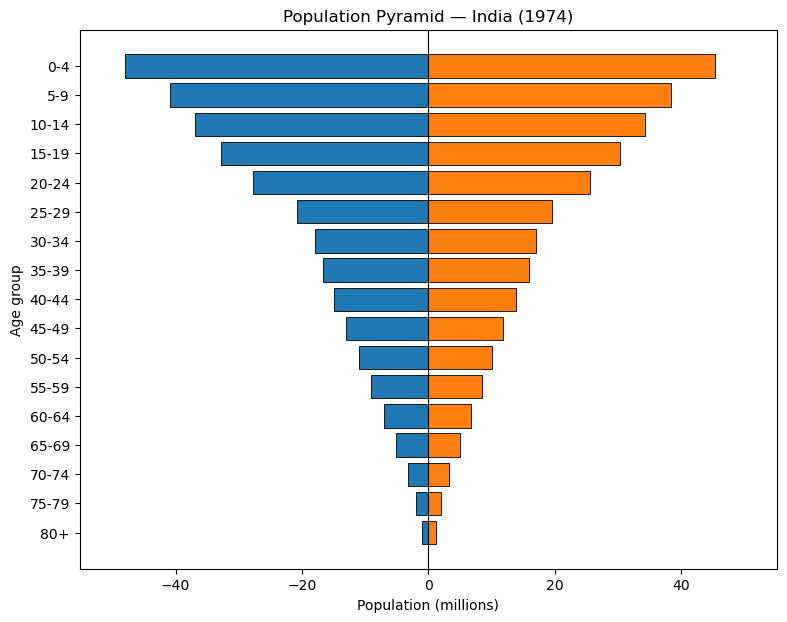

In [48]:
india_df = population_df(years=(1960, 2024), area="India")
bang_df  = population_df(years=(1960, 2024), area="Bangladesh")
pak_df   = population_df(years=(1960, 2024), area="Pakistan")

plot_population_pyramid_5y(india_df, "India", 1974)
plot_population_pyramid_5y(bang_df, "Bangladesh", 1974)
plot_population_pyramid_5y(pak_df, "Pakistan", 1974)
plt.show()

<h4> Combined Multi-Country Chart - India, Pakistan and Bangladesh in 1980 </h4>

NameError: name 'FuncFormatter' is not defined

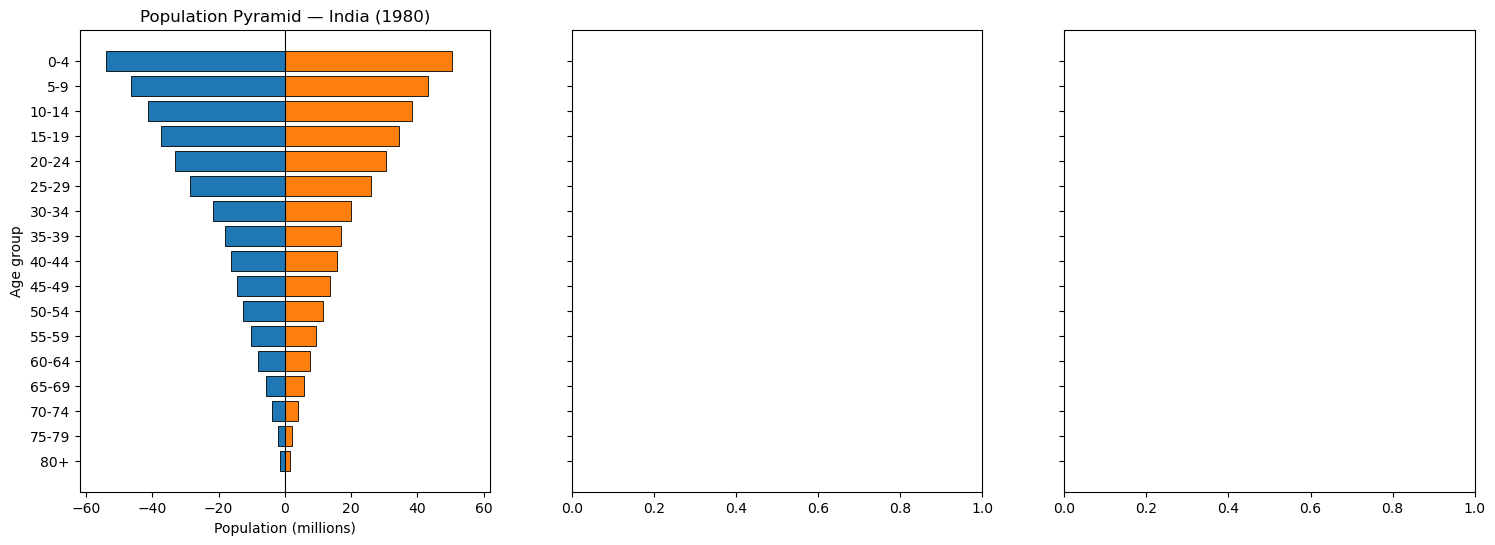

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
plot_population_pyramid_5y(india_df, "India", 1980, ax=axes[0])
plot_population_pyramid_5y(bang_df,  "Bangladesh", 1980, ax=axes[1])
plot_population_pyramid_5y(pak_df,   "Pakistan", 1980, ax=axes[2])
plt.show()

# 5. Studying India v.s Bangladesh v.s Pakistan Pre- and Post- Liberation War

NameError: name 'FuncFormatter' is not defined

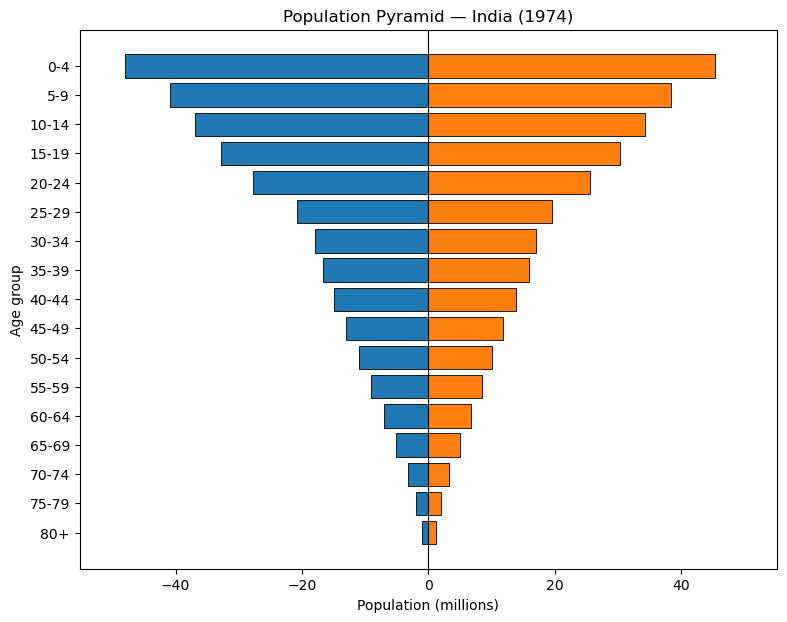

In [46]:
india_df = population_df(years=(1960, 2024), area="India")
bang_df  = population_df(years=(1960, 2024), area="Bangladesh")
pak_df   = population_df(years=(1960, 2024), area="Pakistan")

plot_population_pyramid_5y(india_df, "India", 1974)
plot_population_pyramid_5y(bang_df, "Bangladesh", 1974)
plot_population_pyramid_5y(pak_df, "Pakistan", 1974)
plt.show()

## Population Growth Rate
First we want to visualize population growth rate

In [ ]:
def population_growth_rate(years,country):
    
    def country_id(country):
        single_country = wbdata.get_countries(query=f"^{re.escape(country)}$")
        return single_country[0]["id"]

    country_id = country_id(country)
    indicators = {"SP.POP.GROW" : "Population growth (annual %)"}

    country_df = wbdata.get_dataframe(indicators, country = country_id, parse_dates = True)

    start, end = years
    growth_adjusted = country_df[(country_df.index.year >= start) & (country_df.index.year <= end)]

    return growth_adjusted.rename(columns = lambda c: country if c == growth_adjusted.columns[0] else c)
    

rate_BGD = population_growth_rate([1961, 1980], "Bangladesh")
rate_IND = population_growth_rate([1961, 1980], "India")
rate_PAK = population_growth_rate([1961, 1980], "Pakistan")


In [ ]:
pop_growth_rate = rate_BGD.join([rate_IND, rate_PAK])
pop_growth_rate.head()

In [ ]:

plt.plot(pop_growth_rate, label = pop_growth_rate.columns )
plt.ylabel("Annual %")
plt.xlabel("Date")
plt.title("Population growth (annual %)")
plt.legend()

### Population growth rate = Birth rate−Death rate+Net migration

The graph clearly shows a major dip around 1971 for Bangladesh, for almost a 1.5% decrease, where many either died or fled to India, as India was located in between the now Bangladesh and Pakistan. Later we will examine both fertility and mortality rate. 

We also want to examine rural v.s urban population growth to grasp if there was uneven impact of the war to urban and rural population.
Below we visualize the comparison or rural v.s urban population growth.

In [7]:
def pop_growth(years,country, indicator):
    
    def country_id(country):
        single_country = wbdata.get_countries(query=f"^{re.escape(country)}$")
        return single_country[0]["id"]

    country_id = country_id(country)


    country_df = wbdata.get_dataframe(indicator, country = country_id, parse_dates = True)

    start, end = years
    growth_adjusted = country_df[(country_df.index.year >= start) & (country_df.index.year <= end)]

    return growth_adjusted.rename(columns = lambda c: country if c == growth_adjusted.columns[0] else c)
    
rural_BGD = pop_growth([1961, 1980], "Bangladesh", {"SP.RUR.TOTL.ZG": "Rural population growth (annual %)"})
rural_IND = pop_growth([1961, 1980], "India",  {"SP.RUR.TOTL.ZG": "Rural population growth (annual %)"})
rural_PAK = pop_growth([1961, 1980], "Pakistan",  {"SP.RUR.TOTL.ZG": "Rural population growth (annual %)"})

Key '7261572386511554378' not in persistent cache.


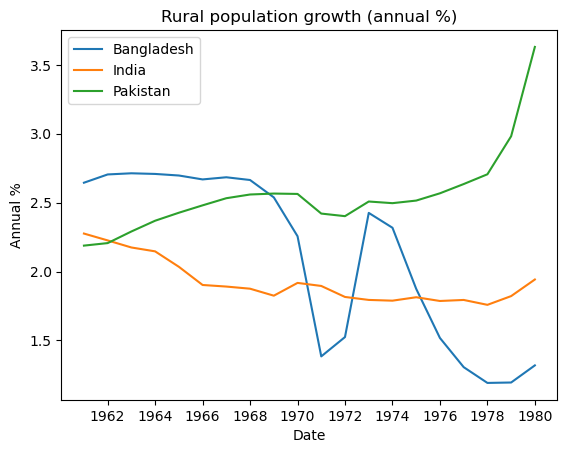

In [8]:
rural_pop_growth = rural_BGD.join([rural_IND, rural_PAK])
plt.plot(rural_pop_growth, label = rural_pop_growth.columns)
plt.ylabel("Annual %")
plt.xlabel("Date")
plt.title("Rural population growth (annual %)")
plt.legend()

In [9]:
urban_BGD = pop_growth([1961, 1980], "Bangladesh", {'SP.URB.GROW':'Urban population growth (annual %)'})
urban_IND = pop_growth([1961, 1980], "India",  {'SP.URB.GROW':'Urban population growth (annual %)'})
urban_PAK = pop_growth([1961, 1980], "Pakistan",  {'SP.URB.GROW':'Urban population growth (annual %)'})

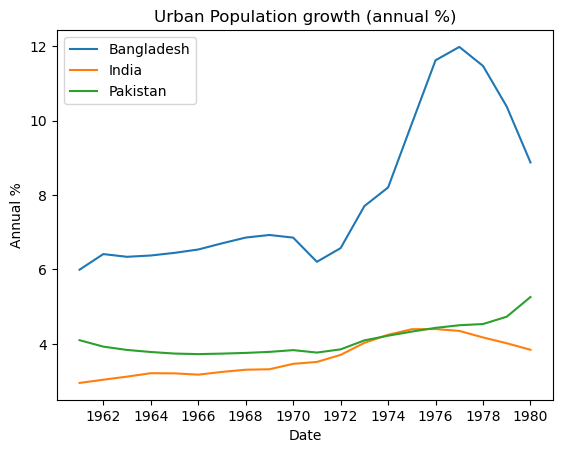

In [10]:
urban_pop = urban_BGD.join([urban_IND, urban_PAK])
plt.plot(urban_pop, label = urban_pop.columns)
plt.ylabel("Annual %")
plt.xlabel("Date")
plt.title("Urban Population growth (annual %)")
plt.legend()

From these two graphs, the population growth curve for Bangladesh and Pakistan looks very similar with about the same magnitude of decrease aroung 1971. However, we discovered a significant distinction between urban population and rural population in Bangladesh. Rural population decreased by 1.5%, but urban population drastically increased by 6%, which indicates fast urbanization. 

Below we examine this change more closely by only focusing on Bangladesh.


Text(0, 0.5, 'Percent (%)')

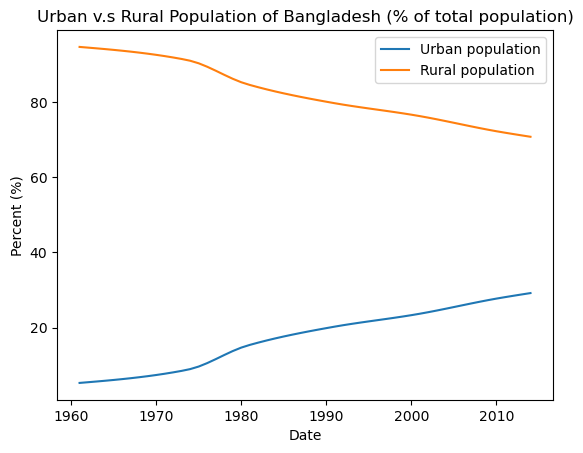

In [12]:
pct_urban_BGD = wbdata.get_dataframe({"SP.URB.TOTL.IN.ZS" : "Urban population (% of total population)"},
                                     country = 'BGD', parse_dates = True)
pct_rural_BGD = wbdata.get_dataframe({'SP.RUR.TOTL.ZS':'Rural population (% of total population)'},
                                     country = 'BGD', parse_dates = True)
compare_pct = pct_urban_BGD.join(pct_rural_BGD)
plt.plot(compare_pct[(compare_pct.index.year >=1961)&(compare_pct.index.year <=2014)], label =['Urban population', 'Rural population'] )
plt.legend()
plt.title('Urban v.s Rural Population of Bangladesh (% of total population)')
plt.xlabel('Date')
plt.ylabel('Percent (%)')



Looking at percentage of total population  we can see the symmetry of decrease in rural population and increase in urban population. Corresponding with the rapid refugee return and urbanization in Bangladesh after war, up until 1977, the election of Ziaur Rahman. During his presidency, he pushed for self-reliance, rural development, and free-market that led to fast economic and industrial growth. 



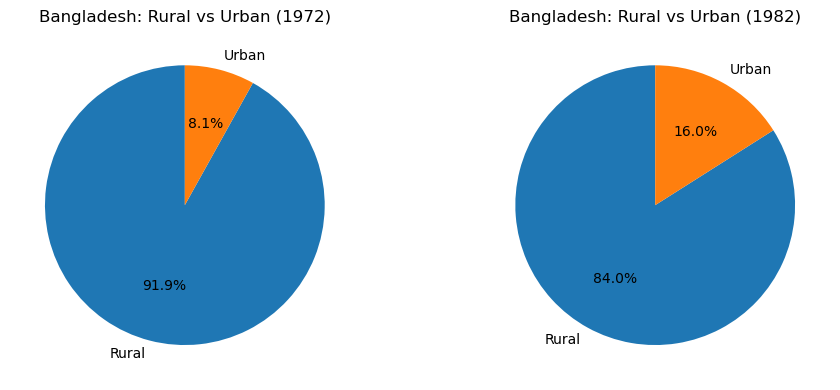

In [13]:


# World Bank indicators
IND = {
    "SP.RUR.TOTL": "Rural",
    "SP.URB.TOTL": "Urban",
}

country = "Bangladesh"
country_id = wbdata.get_countries(query="^Bangladesh$")[0]["id"]

df = wbdata.get_dataframe(
    indicators=IND,
    country=country_id,
    parse_dates=True,
    skip_cache=True
)

# Convert index to year int
df.index = df.index.year

# Grab the two years
years = [1972, 1982]
sub = df.loc[years, ["Rural", "Urban"]].copy()

# (Optional) ensure numeric
sub["Rural"] = pd.to_numeric(sub["Rural"], errors="coerce")
sub["Urban"] = pd.to_numeric(sub["Urban"], errors="coerce")

# Plot: 2 pies side-by-side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, y in zip(axes, years):
    vals = sub.loc[y].values
    labels = sub.columns.tolist()
    ax.pie(vals, labels=labels, autopct="%.1f%%", startangle=90)
    ax.set_title(f"{country}: Rural vs Urban ({y})")

plt.tight_layout()
plt.show()


Before 1971, rural population comprises the vast majority of total population. After a decade since the Liberation, along with the new election of President Rahman, the urban population nearly doubled in absolute size over this decade, indicating a significant shift in population dynamics. This growth reflected accelerated urbanization, recovery, and the establishment of Bangladesh. 

# Fertility Rate Comparison

In [15]:
#Fertility rates graphed
tot_fertility_rate = {"SP.DYN.TFRT.IN" : "Fertility rate, total (births per woman)"}

def fertility(years, country):
    
    def country_id(country):
        single_country = wbdata.get_countries(query = country)
        return single_country[0]["id"]

    country_id = country_id(country)
    df = {}
        
    country_df = wbdata.get_dataframe(tot_fertility_rate, country = country_id, parse_dates = True)

    start, end = years
    fertility_adjusted = country_df[(country_df.index.year >= start) & (country_df.index.year <= end)]

    return fertility_adjusted.rename(columns = lambda c: country if c == fertility_adjusted.columns[0] else c)
    
fert_bgd = fertility([1961, 1980], "Bangladesh")
fert_ind = fertility([1961, 1980], "India")
fert_pak = fertility([1961, 1980], "^Pakistan")

Text(0.5, 1.0, 'BGD, IND, PAK Fertility Rate')

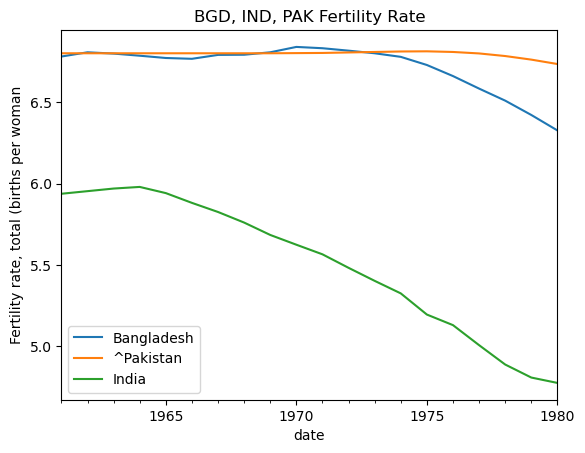

In [16]:
fertility_bangladesh = fert_bgd.copy()
all_fertility = fertility_bangladesh.join(fert_pak).join(fert_ind)

all_fertility.plot()
plt.ylabel('Fertility rate, total (births per woman')
plt.title("BGD, IND, PAK Fertility Rate")

In Bangladesh, a decline in birth rates occurred in the years following the Liberation War.  Since the War lasted less than a year, birth rates saw no significant change during this time. Pakistan's birth rate was steady throughout this time frame.
India’s fertility rate had began declining in 1964.  Starting around 1974, Bangladesh and India saw parallel declinding fertility rates.


# Infant Mortality 

In [66]:
#Infant mortality rates graphed
def infant_mortality(years, gender, country):
    
    def country_id(country):
        single_country = wbdata.get_countries(query = country)
        return single_country[0]["id"]

    country_id = country_id(country)
    df = {}
    if gender == "female":
        df = {"SH.DTH.IMRT.FE" : "Number of infant deaths, female"}
        title = "Number of infant deaths, female"
    elif gender == "male": 
        df = {"SH.DTH.IMRT.MA" : "Number of infant deaths, male"}
        title = "Number of infant deaths, male"
    else: 
        return "Please put gender as either 'male' or 'female'."
        
    country_df = wbdata.get_dataframe(df, country = country_id, parse_dates = True)

    start, end = years
    mortality_adjusted = country_df[(country_df.index.year >= start) & (country_df.index.year <= end)]
    new_col_name = f"{country}_{gender}"

    return mortality_adjusted.rename(columns = {mortality_adjusted.columns[0]: new_col_name})
    

inf_MA_BGD = infant_mortality([1961, 1980], "male", "Bangladesh")
inf_FE_BGD = infant_mortality([1961, 1980], "female", "Bangladesh")
inf_MA_IND = infant_mortality([1961, 1980], "male", "India")
inf_FE_IND = infant_mortality([1961, 1980], "female", "India")
inf_MA_PAK = infant_mortality([1961, 1980], "male", "^Pakistan")
inf_FE_PAK = infant_mortality([1961, 1980], "female", "^Pakistan")


Text(0.5, 1.0, 'BGD, IND, PAK Female Infant deaths')

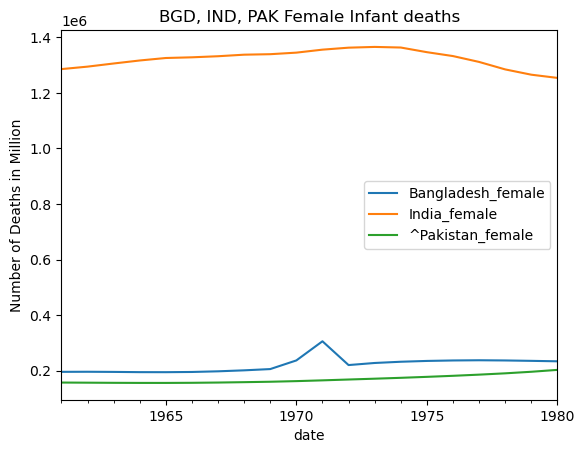

In [67]:
infant_mortality_female_BGD = inf_FE_BGD.copy()
all_infant_mort_fe = infant_mortality_female_BGD.join(inf_FE_IND).join(inf_FE_PAK)

all_infant_mort_fe.plot()
plt.ylabel('Number of Deaths in Million')
plt.title("BGD, IND, PAK Female Infant deaths")


Text(0.5, 1.0, 'BGD, IND, PAK Male Infant deaths')

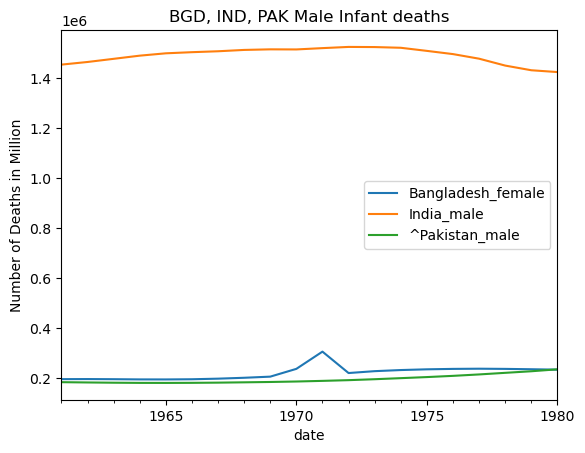

In [68]:
infant_mortality_male_BGD = inf_FE_BGD.copy()
all_infant_mort_ma = infant_mortality_male_BGD.join(inf_MA_IND).join(inf_MA_PAK)
all_infant_mort_ma.plot()
plt.ylabel('Number of Deaths in Million')
plt.title("BGD, IND, PAK Male Infant deaths")

Text(0.5, 1.0, 'Number of infant deaths: India')

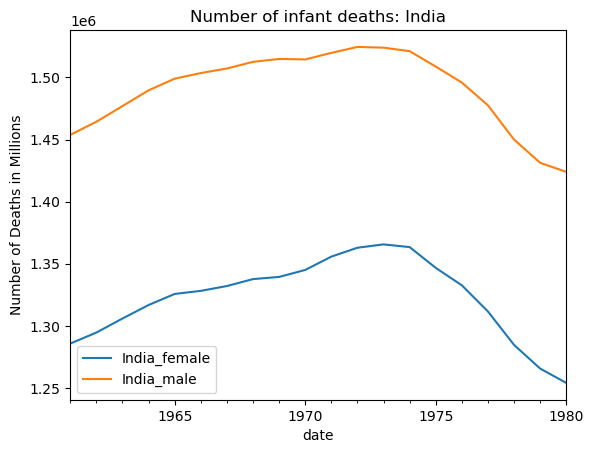

In [69]:
#Number of infant deaths in India graphed (genders compared)
new_inf_FE_IND = inf_FE_IND.copy()
all_inf_IND = new_inf_FE_IND.join(inf_MA_IND)
all_inf_IND.plot()
plt.ylabel("Number of Deaths in Millions")
plt.title("Number of infant deaths: India")

Text(0.5, 1.0, 'Number of infant deaths: Bangladesh')

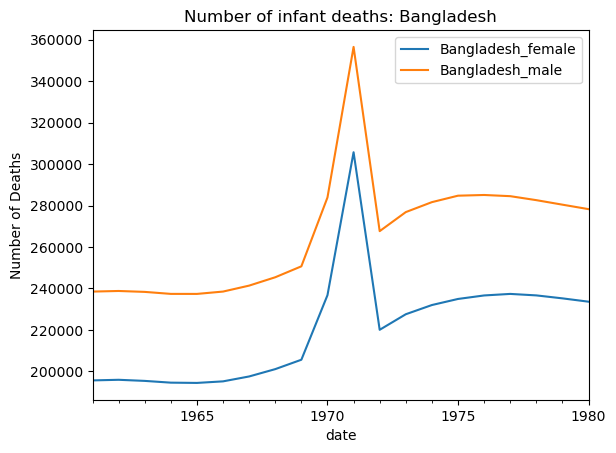

In [70]:
#Number of infant deaths in Bangladesh graphed (genders compared)
new_inf_FE_BGD = inf_FE_BGD.copy()
all_inf_BGD = new_inf_FE_BGD.join(inf_MA_BGD)
all_inf_BGD.plot()
plt.ylabel("Number of Deaths")
plt.title("Number of infant deaths: Bangladesh")

Text(0.5, 1.0, 'Number of infant deaths: Pakistan')

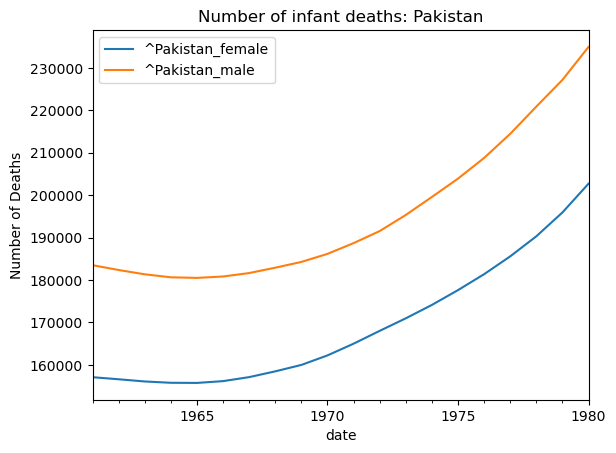

In [71]:
#Number of infant deaths in Pakistan graphed (genders compared)
new_inf_FE_PAK = inf_FE_PAK.copy()
all_inf_PAK = new_inf_FE_PAK.join(inf_MA_PAK)
all_inf_PAK.plot()
plt.ylabel("Number of Deaths")
plt.title("Number of infant deaths: Pakistan")

# Crude Mortality

Text(0.5, 1.0, 'Number of deaths in India, Pakistan and Bangladesh')

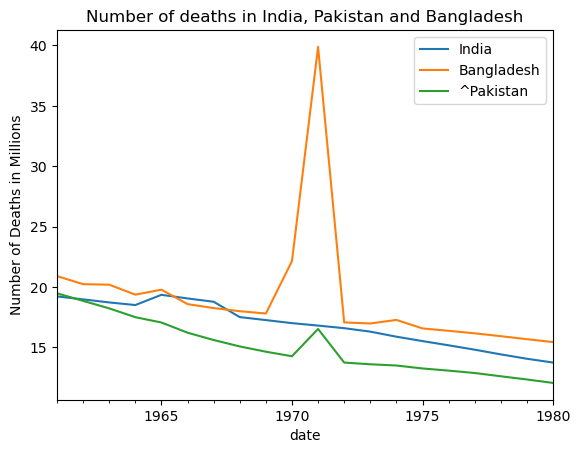

In [72]:
#Crude mortality in India, Bangladesh and Pakistan compared [1961-1980]
def crude_mortality(years, country):
    
    def country_id(country):
        single_country = wbdata.get_countries(query = country)
        return single_country[0]["id"]

    country_id = country_id(country)
    df = {"SP.DYN.CDRT.IN" : "Death rate, crude (per 1,000 people)"}
        
    country_df = wbdata.get_dataframe(df, country = country_id, parse_dates = True)

    start, end = years
    mortality_adjusted = country_df[(country_df.index.year >= start) & (country_df.index.year <= end)]
    new_col_name = f"{country}"

    return mortality_adjusted.rename(columns = {mortality_adjusted.columns[0]: new_col_name})

cr_mort_IND = crude_mortality([1961, 1980], "India")
cr_mort_BGD = crude_mortality([1961, 1980], "Bangladesh")
cr_mort_PAK = crude_mortality([1961, 1980], "^Pakistan")

all_cr_mort = cr_mort_IND.join(cr_mort_BGD).join(cr_mort_PAK)
all_cr_mort.plot()
plt.ylabel("Number of Deaths in Millions")
plt.title("Number of deaths in India, Pakistan and Bangladesh")